<a href="https://colab.research.google.com/github/zhus-dika/railways_caclulations/blob/main/railways_calculations_volume_data_p1_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐸 Getting data from stat.gov

## 🦉 Download spreadsheets & make dataframes

### 🦤 Install need packages

In [1]:
! pip install pyexcel pyexcel-xls pyexcel-xlsx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 4.5 MB/s eta 0:00:00


### 🪲 Imports

In [2]:
import glob
from os import listdir
import os
from os.path import isfile, join
import pyexcel as p

from openpyxl import load_workbook

import pandas as pd

import subprocess

### 🐤 Useful methods

In [3]:
def convert2xlsx():

  files_xlsx = glob.glob("*.xls*")
  files_xls = glob.glob("*.xls")
  files_xlsx.sort(key=os.path.getmtime)
  if len(files_xls) > 0:
    for idx, i in enumerate(files_xls):
        p.save_book_as(file_name=i,
                      dest_file_name=i.replace('.xls', '.xlsx'))
        os.remove(i)
        files_xlsx[idx] = files_xlsx[idx].replace('.xls', '.xlsx')
  return files_xlsx

In [4]:
def prepare_files_rar():
  # get all files to make correct ordering
  files = glob.glob("*")
  files.sort(key=os.path.getmtime)

  file2int = {}

  for idx, file in enumerate(files):
    file2int[file.split('.')[0]] = idx

  # unrar .rar files and remove them
  files_rar = glob.glob("*.rar")

  for file_rar in files_rar:
    correct = subprocess.run(['unrar', '-y', 'x', file_rar], check=True, text=True)
    correct = subprocess.run(['rm', '-r', file_rar], check=True, text=True)

  # move inner files with extensions .xls & .xlsx
  for path in files_rar:
    files = os.listdir(path=path[:-4])
    files_xls = glob.glob(f"{path[:-4]}/*.xls")

    if len(files_xls) > 1:
      for file_xls in files_xls:
        if os.path.join(path[:-4], "3. Производство промышленной продукции в натуральном выражении.xls") != file_xls:
          correct = subprocess.run(['rm', '-r', file_xls], check=True, text=True)

    files_xls = glob.glob(f"{path[:-4]}/*.xls")
    for selected_file in files_xls:
      os.rename(selected_file, f"{path[:-4]}.xls")
    files_xlsx = glob.glob(f"{path[:-4]}/*.xlsx")
    for selected_file in files_xlsx:
      os.rename(selected_file, f"{path[:-4]}.xlsx")


  files_xlsx = glob.glob("*.xls*")
  files_xls = glob.glob("*.xls")

  files_xlsx = convert2xlsx()

  files_xlsx_upd = [i for i in files_xlsx]

  for file_xlsx in files_xlsx:
    files_xlsx_upd[file2int[file_xlsx.split('.')[0]]] = file_xlsx

  return files_xlsx_upd

In [5]:
def generate_table_data(files_xlsx):

  table_data = []
  for i in files_xlsx:
    wb = load_workbook(i)
    main_sheets = ["3 табл", "3", "3 ", " 3", "Лист1", "бюллетень 2 мес", "бюллетень 4 мес", "бюллетень 6 мес", "бюллетень 8 мес", "бюллетень 10 мес", "бюллетень 12 мес", "Данные"]
    for main_sheet in main_sheets:
      if main_sheet in wb.sheetnames:
        table_data.append(wb[main_sheet])
        break
  return table_data

In [6]:
def fill_volumes(table_data, year, name_column='J'):

  commodities_names = []

  table_rows = []
  for table_num in range(len(table_data)):
    commodities_names_2 = []
    rows = {}
    for i in range(8, 354):
      if table_data[table_num]['I'+str(i)].value != None and table_data[table_num][name_column + str(i)].value != None:
        value = table_data[table_num][name_column+str(i)].value
        value = value.replace(',', ' ').replace('.', ' ').replace(')', ' ').replace('(', ' ').replace('-', ' ').replace('из ', ' ').replace(' нее:', ' ').replace(' него:', ' ').replace(' них:', ' ').replace("\n", " ").lower()
        name = " ".join(value.split())
        if 'гранулы крошка каменная и порошок каменный; галька гравий щебень или камень дробленый тыс куб м' == name:
          name = 'гранулы крошка каменная и порошок каменный; галька гравий щебень или камень дробленный тыс куб м'
        if 'золото необработанное и полуобработанное или в виде порошка кг' == name:
          name = 'золото необработанное и полу обработанное или в виде порошка кг'
        commodities_names_2.append(name)
        rows[name] = i
    table_rows.append(rows)
    commodities_names.append(commodities_names_2)
  commodities_volume = {str(i) + '_' + str(year): [] for i in range(1, 13)}
  commodities_volume['name'] = []
  common_names = set(commodities_names[0])
  for i in range(1, 6):
    common_names = common_names & set(commodities_names[i])

  for name in common_names:

    commodities_volume['name'].append(name)

    for table_num in range(len(table_data)):

      i = table_rows[table_num][name]
      val_volume_1 = table_data[table_num]['B'+str(i)].value
      commodities_volume[str(2 * table_num + 1) + '_' + str(year)].append(val_volume_1)
      val_volume_2 = table_data[table_num]['C'+str(i)].value
      commodities_volume[str(2 * table_num + 2)  + '_' + str(year)].append(val_volume_2)
  return commodities_volume

### 🦜 2018 year per month

In [7]:
! rm -r *

In [8]:
# ! wget https://stat.gov.kz/api/iblock/element/49161/file/ru/

In [9]:
! wget 'https://stat.gov.kz/upload/iblock/902/aobfv3djds58bmyhkqaktyjpzb2iuybc/2_2018_%D0%91-04-01-%D0%9C.rar' #1-2
! wget 'https://stat.gov.kz/upload/iblock/fb0/9j1tlw2sf4gcrm0q9vjhrl6o9t9rc7v8/4_2018_%D0%91-04-01-%D0%9C.rar' #1-4
! wget 'https://stat.gov.kz/upload/iblock/919/dwds1m0pf83dbdpucwfa0e16o162wm4f/6_2018_%D0%91-04-01-%D0%9C.rar' #1-6
! wget 'https://stat.gov.kz/upload/iblock/7b5/qf2p59p7wnjpbgy23say98ls1ruzf3x5/8_2018_%D0%91-04-01-%D0%9C.rar' #1-8
! wget 'https://stat.gov.kz/upload/iblock/ef8/kj8ilh6pam18b1m5bkfgx8pcf4h7iav9/10_2018_%D0%91-04-01-%D0%9C.rar' #1-10
! wget 'https://stat.gov.kz/upload/iblock/890/bw4d5zwmn1i1rosuz2ifvfa4qgw7haa1/12_2018_%D0%91-04-01-%D0%9C.rar' #1-12

--2025-02-11 04:01:40--  https://stat.gov.kz/upload/iblock/902/aobfv3djds58bmyhkqaktyjpzb2iuybc/2_2018_%D0%91-04-01-%D0%9C.rar
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154352 (151K) [application/x-rar-compressed]
Saving to: ‘2_2018_Б-04-01-М.rar’

2_2018_Б-04-01-М.ra 100%[===================>] 150.73K   284KB/s    in 0.5s    

2025-02-11 04:01:42 (284 KB/s) - ‘2_2018_Б-04-01-М.rar’ saved [154352/154352]

--2025-02-11 04:01:42--  https://stat.gov.kz/upload/iblock/fb0/9j1tlw2sf4gcrm0q9vjhrl6o9t9rc7v8/4_2018_%D0%91-04-01-%D0%9C.rar
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154410 (151K) [application/x-rar-compressed]
Saving to: ‘4_2018_Б-04-01-М.rar’

4_2018_Б-04-01-М.ra 100%[===================>] 150.79K   284

In [10]:
files_xlsx = prepare_files_rar()

In [11]:
df_2018 = pd.DataFrame(fill_volumes(generate_table_data(files_xlsx), 2018))
df_2018

,1_2018,2_2018,3_2018,4_2018,5_2018,6_2018,7_2018,8_2018,9_2018,10_2018,11_2018,12_2018,name
0,41854.0,42173.0,45573.0,20528.0,16562.0,2268.0,824.0,4683,5560.0,14626,29265.0,59218,сахар сырец или сахар рафинированный тростнико...
1,114.0,55.0,55.0,55.0,38.0,51.0,51.0,92,92.0,83,102.0,102,кумыс тонн
2,192510.0,193673.0,163658.0,142963.0,181950.0,203648.0,208301.0,183550,185335.0,205721,199724.0,208239,кислота серная в моногидрате тонн
3,207.8,398.6,398.5,401.2,327.8,327.6,335.6,495,495.3,493.7,421.3,415.3,белье постельное тыс штук
4,750.0,1162.0,700.0,878.0,1133.0,753.0,1144.0,1112,1132.0,762,671.0,1087,насосы центробежные для перекачки жидкостей; н...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,21.8,22.8,29.0,30.7,38.5,46.1,53.3,60.1,46.7,46.1,40.9,33.3,концентраты марганцевые тыс тонн
246,2639.6,2213.7,2046.3,2680.9,2224.4,1578.1,1342.3,3876.5,3437.4,2277.7,2836.6,2514.1,водка тыс литров
247,47939.0,64834.0,87712.0,101604.0,86045.0,84682.0,77806.0,79245,92451.0,88252,86892.0,79370,кирпичи силикатные и шлаковые тонн
248,7425.0,1289.0,11617.0,67722.0,97880.0,32605.0,60169.0,76198,79715.0,42178,16850.0,7383,добавки для цементов растворов строительных ил...


### 🐨 2019 year per month

In [12]:
! rm -r *

In [13]:
# ! wget https://stat.gov.kz/api/iblock/element/49133/file/ru/

In [14]:
! wget 'https://stat.gov.kz/upload/iblock/3d0/spwao8pmj590p21oj6jjmrsa84gcaeup/02_2019_%D0%91-04-01-%D0%9C.rar' #1-2
! wget 'https://stat.gov.kz/upload/iblock/577/f20py2ccajbmf5o4kacuiv355iz42wv6/04_2019_%D0%91-04-01-%D0%9C.xls' #1-4
! wget 'https://stat.gov.kz/upload/iblock/fe4/z6wj3wuac71s3u7xc6pv26ozo0yba8sp/06_2019_%D0%91-04-01-%D0%9C.xls' #1-6
! wget 'https://stat.gov.kz/upload/iblock/0e7/jlalo81y1p4tdoi01u3yojfccv7q99h2/08_2019_%D0%91-04-01-%D0%9C.xls' #1-8
! wget 'https://stat.gov.kz/upload/iblock/d29/79ljbm8q3ibp0svmm6y4us55f3ql6xlo/10_2019_%D0%91-04-01-%D0%9C.xls' #1-10
! wget 'https://stat.gov.kz/upload/iblock/505/b3iaejrhcby1o5qf3wu5tlarbeqwhu7c/12_2019_%D0%91-04-01-%D0%9C.xls' #1-12

--2025-02-11 04:01:54--  https://stat.gov.kz/upload/iblock/3d0/spwao8pmj590p21oj6jjmrsa84gcaeup/02_2019_%D0%91-04-01-%D0%9C.rar
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154632 (151K) [application/x-rar-compressed]
Saving to: ‘02_2019_Б-04-01-М.rar’

02_2019_Б-04-01-М.r 100%[===================>] 151.01K   285KB/s    in 0.5s    

2025-02-11 04:01:55 (285 KB/s) - ‘02_2019_Б-04-01-М.rar’ saved [154632/154632]

--2025-02-11 04:01:55--  https://stat.gov.kz/upload/iblock/577/f20py2ccajbmf5o4kacuiv355iz42wv6/04_2019_%D0%91-04-01-%D0%9C.xls
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276480 (270K) [application/vnd.ms-excel]
Saving to: ‘04_2019_Б-04-01-М.xls’

04_2019_Б-04-01-М.x 100%[===================>] 270.00K   38

In [15]:
files_xlsx = prepare_files_rar()

In [16]:
df_2019 = pd.DataFrame(fill_volumes(generate_table_data(files_xlsx), 2019))
df_2019

,1_2019,2_2019,3_2019,4_2019,5_2019,6_2019,7_2019,8_2019,9_2019,10_2019,11_2019,12_2019,name
0,28205.0,24293,7432,12269,18881.0,29604.0,22848.0,17944.0,17980.0,24446.0,21542.0,27458.0,сахар сырец или сахар рафинированный тростнико...
1,51.0,116,116,116,63.0,63.0,63.0,97.0,97.0,97.0,112.0,112.0,кумыс тонн
2,201723.0,211438,188589,197200,134462.0,213342.0,187180.0,202532.0,152391.0,175624.0,199130.0,215574.0,кислота серная в моногидрате тонн
3,319.0,590.7,587.4,544.4,768.5,517.8,548.8,550.3,556.7,915.0,1071.9,503.8,белье постельное тыс штук
4,87.0,976,938,1225,1068.0,907.0,1195.0,1085.0,747.0,1356.0,965.0,869.0,насосы центробежные для перекачки жидкостей; н...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,1150.1,1549,2481.5,1573.8,1296.5,1988.7,1151.1,1286.2,1586.8,1728.8,1900.2,1806.4,водка тыс литров
233,49908.0,61660,72970,87057,73900.0,63143.0,77486.0,91762.0,96519.0,95887.0,90811.0,86301.0,кирпичи силикатные и шлаковые тонн
234,90204.2,91073,122458.8,165417.4,156734.7,148692.1,183705.7,170523.2,145281.2,97557.1,105601.5,112804.1,напитки безалкогольные прочие тыс литров
235,1005.0,2254,46551,91614,122188.0,129075.0,112624.0,105971.0,80482.0,75392.0,51220.0,20811.0,добавки для цементов растворов строительных ил...


In [17]:
df = df_2018.set_index('name').join(df_2019.set_index('name'), on='name')

### 🐻 2020 year per month

In [18]:
! rm -r *

In [19]:
# ! wget https://stat.gov.kz/api/iblock/element/49113/file/ru/

In [20]:
! wget 'https://stat.gov.kz/upload/iblock/a8a/h7odaow8re9jy36o2defzgd8lloud61b/02_2020_%D0%91-04-01-%D0%9C.xls' #1-2
! wget 'https://stat.gov.kz/upload/iblock/6a6/o9fy7vi1unm3f6qyyblpbbr0biyx7ubo/%D0%91-04-01-%D0%9C%20(4%202020).xls' #1-4
! wget 'https://stat.gov.kz/upload/iblock/29d/t128ej0f1edw811ho2491cat3x3fgm1e/%D0%91-04-01-%D0%9C%20(6%202020).xls' #1-6
! wget 'https://stat.gov.kz/upload/iblock/a77/xum5h2ea3anc1gy960xz0z4fibfc2qxn/%D0%91-04-01-%D0%9C(8%202020).rar' #1-8
! wget 'https://stat.gov.kz/upload/iblock/b86/h9a0m5kw5wqvk9yt0d9e4ko5ozd862es/%D0%91-04-01-%D0%9C(10%202020).rar' #1-10
! wget 'https://stat.gov.kz/upload/iblock/d67/t8bp3s2mobqxlbp7aobn0m0di43etmmz/%D0%91-04-01-%D0%9C%20(12%202020).rar' #1-12

--2025-02-11 04:02:05--  https://stat.gov.kz/upload/iblock/a8a/h7odaow8re9jy36o2defzgd8lloud61b/02_2020_%D0%91-04-01-%D0%9C.xls
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 287232 (280K) [application/vnd.ms-excel]
Saving to: ‘02_2020_Б-04-01-М.xls’

02_2020_Б-04-01-М.x 100%[===================>] 280.50K   396KB/s    in 0.7s    

2025-02-11 04:02:06 (396 KB/s) - ‘02_2020_Б-04-01-М.xls’ saved [287232/287232]

--2025-02-11 04:02:06--  https://stat.gov.kz/upload/iblock/6a6/o9fy7vi1unm3f6qyyblpbbr0biyx7ubo/%D0%91-04-01-%D0%9C%20(4%202020).xls
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 312320 (305K) [application/vnd.ms-excel]
Saving to: ‘Б-04-01-М (4 2020).xls’

Б-04-01-М (4 2020). 100%[===================>] 305.00K   

In [21]:
files_xlsx = prepare_files_rar()

df_2020 = pd.DataFrame(fill_volumes(generate_table_data(files_xlsx), 2020))

In [22]:
df_2020

,1_2020,2_2020,3_2020,4_2020,5_2020,6_2020,7_2020,8_2020,9_2020,10_2020,11_2020,12_2020,name
0,5528,2192,2792,12038,4204,25569,12560,4395,8304,22603,35406,39640,сахар сырец или сахар рафинированный тростнико...
1,63,79,79,79,82,82,82,132,132,132,131,131,кумыс тонн
2,214087,179613,184141,168062,169494,176008,154755,171938,154831,181825,189998,199312,кислота серная в моногидрате тонн
3,473.5,709.1,643.4,666.9,606,672.5,669.6,623,592.3,663.8,576.4,541,белье постельное тыс штук
4,1086,1134,661,762,745,752,795,1328,1560,424,685,334,насосы центробежные для перекачки жидкостей; н...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,70312,76392,102565,92707,85861,88725,82857,98399,104887,101534,117364,122792,кирпичи силикатные и шлаковые тонн
272,102407.8,119903.5,157379.7,109239.7,150440.6,184462.7,171636.8,174273.1,133371,113709.1,122173.8,125220.2,напитки безалкогольные прочие тыс литров
273,1380.5,1494.2,1598.3,2204,1653.4,2135.7,1558.4,1679.5,2212.2,1832.9,2375.9,2102.8,водка тыс литров
274,4970,8346,35566,31777,52648,124460,80328,102954,80688,122676,57158,31716,добавки для цементов растворов строительных ил...


In [23]:
df = df.join(df_2020.set_index('name'), on='name')

In [24]:
df

,1_2018,2_2018,3_2018,4_2018,5_2018,6_2018,7_2018,8_2018,9_2018,10_2018,...,3_2020,4_2020,5_2020,6_2020,7_2020,8_2020,9_2020,10_2020,11_2020,12_2020
name,,,,,,,,,,,,,,,,,,,,,
сахар сырец или сахар рафинированный тростниковый или свекловичный; патока меласса тонн,41854.0,42173.0,45573.0,20528.0,16562.0,2268.0,824.0,4683,5560.0,14626,...,2792,12038,4204,25569,12560,4395,8304,22603,35406,39640
кумыс тонн,114.0,55.0,55.0,55.0,38.0,51.0,51.0,92,92.0,83,...,79,79,82,82,82,132,132,132,131,131
кислота серная в моногидрате тонн,192510.0,193673.0,163658.0,142963.0,181950.0,203648.0,208301.0,183550,185335.0,205721,...,184141,168062,169494,176008,154755,171938,154831,181825,189998,199312
белье постельное тыс штук,207.8,398.6,398.5,401.2,327.8,327.6,335.6,495,495.3,493.7,...,643.4,666.9,606,672.5,669.6,623,592.3,663.8,576.4,541
насосы центробежные для перекачки жидкостей; насосы прочие штук,750.0,1162.0,700.0,878.0,1133.0,753.0,1144.0,1112,1132.0,762,...,661,762,745,752,795,1328,1560,424,685,334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
концентраты марганцевые тыс тонн,21.8,22.8,29.0,30.7,38.5,46.1,53.3,60.1,46.7,46.1,...,30.1,42.2,17,27.4,29.3,47.2,46.7,43.5,13.7,14.9
водка тыс литров,2639.6,2213.7,2046.3,2680.9,2224.4,1578.1,1342.3,3876.5,3437.4,2277.7,...,1598.3,2204,1653.4,2135.7,1558.4,1679.5,2212.2,1832.9,2375.9,2102.8
кирпичи силикатные и шлаковые тонн,47939.0,64834.0,87712.0,101604.0,86045.0,84682.0,77806.0,79245,92451.0,88252,...,102565,92707,85861,88725,82857,98399,104887,101534,117364,122792


### 🦀 2021 year per month

In [25]:
! rm -r *

In [26]:
# ! wget https://stat.gov.kz/api/iblock/element/25859/file/ru/

In [27]:
# Download files

! wget 'https://stat.gov.kz/upload/iblock/c68/qi23tyw55ano3t937wmy34ccjz16md7n/%D0%91-04-01-%D0%9C%20(2%202021).xls' #1-2
! wget 'https://stat.gov.kz/upload/iblock/5ac/er3ckeib0oty9c5eu89z7y21fj9pddah/%D0%91-04-01-%D0%9C(4%202021).xls' #1-4
! wget 'https://stat.gov.kz/upload/iblock/ecb/d762kfgimmp261jo92zit8gcu366tck6/%D0%91-04-01(06%202021)%D0%9C.xls' #1-6
! wget 'https://stat.gov.kz/upload/iblock/06d/r2aw5v5w0gkuqi5l1ip3pbn3se1lub7d/%D0%91-04-01-%D0%9C%20(8%202021).xls' #1-8
! wget 'https://stat.gov.kz/upload/iblock/3d2/p61m6ici74ma0ii2g1uh5mkxxnyx3cpd/%D0%91-04-01-%D0%9C%20(10%202021).xls' #1-10
! wget 'https://stat.gov.kz/upload/iblock/386/frszzq01e16r2ywhp47tqb0nnkzjtwlq/%D0%91-04-01-%D0%9C%20(12%202021).xls' #1-12

--2025-02-11 04:02:22--  https://stat.gov.kz/upload/iblock/c68/qi23tyw55ano3t937wmy34ccjz16md7n/%D0%91-04-01-%D0%9C%20(2%202021).xls
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1282048 (1.2M) [application/vnd.ms-excel]
Saving to: ‘Б-04-01-М (2 2021).xls’

Б-04-01-М (2 2021). 100%[===================>]   1.22M   298KB/s    in 4.6s    

2025-02-11 04:02:27 (273 KB/s) - ‘Б-04-01-М (2 2021).xls’ saved [1282048/1282048]

--2025-02-11 04:02:27--  https://stat.gov.kz/upload/iblock/5ac/er3ckeib0oty9c5eu89z7y21fj9pddah/%D0%91-04-01-%D0%9C(4%202021).xls
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1225728 (1.2M) [application/vnd.ms-excel]
Saving to: ‘Б-04-01-М(4 2021).xls’

Б-04-01-М(4 2021).x 100%[===================>]   1

In [28]:
files_xlsx = convert2xlsx()

df_2021 = pd.DataFrame(fill_volumes(generate_table_data(files_xlsx), 2021))

In [29]:
df_2021

,1_2021,2_2021,3_2021,4_2021,5_2021,6_2021,7_2021,8_2021,9_2021,10_2021,11_2021,12_2021,name
0,23139,11692,29367,19393,30197,22987,22438,7463,28802,23576,22321,35530,сахар сырец или сахар рафинированный тростнико...
1,81,115,115,116,97,116,117,158,158,158,241,241,кумыс тонн
2,190078,173193,187688,167302,185470,146794,194363,165688,178198,221767,178547,219360,кислота серная в моногидрате тонн
3,697.8,785.5,835.7,791.5,906.2,384.6,400.6,620.8,728.8,748.3,690.1,769.6,белье постельное тыс штук
4,727,1489,1275,1120,465,1511,835,831,845,965,1400,1301,насосы центробежные для перекачки жидкостей; н...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,78273,79621,95925,95865,90728,97904,103482,112543,123025,127351,111343,102159,кирпичи силикатные и шлаковые тонн
286,92780.5,123487.9,161655.2,161123.4,181563,223273.8,233442.6,244798,212404.1,166653.7,168709.7,162754.9,напитки безалкогольные прочие тыс литров
287,1685.9,1874.1,1648.9,1506.7,2154,2006.9,2364.5,2960.9,2928.4,3165.2,3133.1,2413.4,водка тыс литров
288,15876,30236,106845,115314,122273,73093,99939,98568,66154,68068,68158,62960,добавки для цементов растворов строительных ил...


In [30]:
df = df.join(df_2021.set_index('name'), on='name')

In [31]:
df

,1_2018,2_2018,3_2018,4_2018,5_2018,6_2018,7_2018,8_2018,9_2018,10_2018,...,3_2021,4_2021,5_2021,6_2021,7_2021,8_2021,9_2021,10_2021,11_2021,12_2021
name,,,,,,,,,,,,,,,,,,,,,
сахар сырец или сахар рафинированный тростниковый или свекловичный; патока меласса тонн,41854.0,42173.0,45573.0,20528.0,16562.0,2268.0,824.0,4683,5560.0,14626,...,29367,19393,30197,22987,22438,7463,28802,23576,22321,35530
кумыс тонн,114.0,55.0,55.0,55.0,38.0,51.0,51.0,92,92.0,83,...,115,116,97,116,117,158,158,158,241,241
кислота серная в моногидрате тонн,192510.0,193673.0,163658.0,142963.0,181950.0,203648.0,208301.0,183550,185335.0,205721,...,187688,167302,185470,146794,194363,165688,178198,221767,178547,219360
белье постельное тыс штук,207.8,398.6,398.5,401.2,327.8,327.6,335.6,495,495.3,493.7,...,835.7,791.5,906.2,384.6,400.6,620.8,728.8,748.3,690.1,769.6
насосы центробежные для перекачки жидкостей; насосы прочие штук,750.0,1162.0,700.0,878.0,1133.0,753.0,1144.0,1112,1132.0,762,...,1275,1120,465,1511,835,831,845,965,1400,1301
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
концентраты марганцевые тыс тонн,21.8,22.8,29.0,30.7,38.5,46.1,53.3,60.1,46.7,46.1,...,16.6,20,38.6,44.7,46.1,54.4,62.9,44.8,24.9,x
водка тыс литров,2639.6,2213.7,2046.3,2680.9,2224.4,1578.1,1342.3,3876.5,3437.4,2277.7,...,1648.9,1506.7,2154,2006.9,2364.5,2960.9,2928.4,3165.2,3133.1,2413.4
кирпичи силикатные и шлаковые тонн,47939.0,64834.0,87712.0,101604.0,86045.0,84682.0,77806.0,79245,92451.0,88252,...,95925,95865,90728,97904,103482,112543,123025,127351,111343,102159


### 🦢 2022 year per month

In [32]:
! rm -r *

In [33]:
# ! wget https://stat.gov.kz/api/iblock/element/25889/file/ru/

In [34]:
# Download files

! wget 'https://stat.gov.kz/upload/iblock/619/kuvf04586dczijein9r530o2lj9k4h9a/%D0%91-04-01-%D0%9C%20(2%202022).xls' #1-2
! wget 'https://stat.gov.kz/upload/iblock/bf7/76q3suej6kom8k8k1jq7l2eku5d6cyrc/%D0%91-04-01-%D0%9C%20(4%202022).xls' #1-4
! wget 'https://stat.gov.kz/upload/iblock/6db/ooibr2vg9jm0hxjq8a4tqni7ppdyj5bc/%D0%91-04-01-%D0%9C%20(6%202022).xls' #1-6
! wget 'https://stat.gov.kz/upload/iblock/e58/fceee9uuxjigtckmckdzgiotgwusod36/%D0%91-04-01-%D0%9C%20(08%202022).xlsx' #1-8
! wget 'https://stat.gov.kz/upload/iblock/b50/2y6sn3sifmk9dcqg9ekc65nvhn0tzth2/%D0%91-04-01-%D0%9C(10%202022).xlsx' #1-10
! wget 'https://stat.gov.kz/upload/iblock/ba3/9ue4r2v84puih1lolmooegwx4cefb4hx/%D0%91-04-01-%D0%9C(12_2022).xlsx' #1-12

--2025-02-11 04:02:56--  https://stat.gov.kz/upload/iblock/619/kuvf04586dczijein9r530o2lj9k4h9a/%D0%91-04-01-%D0%9C%20(2%202022).xls
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1224704 (1.2M) [application/vnd.ms-excel]
Saving to: ‘Б-04-01-М (2 2022).xls’

Б-04-01-М (2 2022). 100%[===================>]   1.17M   292KB/s    in 4.5s    

2025-02-11 04:03:01 (268 KB/s) - ‘Б-04-01-М (2 2022).xls’ saved [1224704/1224704]

--2025-02-11 04:03:01--  https://stat.gov.kz/upload/iblock/bf7/76q3suej6kom8k8k1jq7l2eku5d6cyrc/%D0%91-04-01-%D0%9C%20(4%202022).xls
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1229312 (1.2M) [application/vnd.ms-excel]
Saving to: ‘Б-04-01-М (4 2022).xls’

Б-04-01-М (4 2022). 100%[===================>]

In [35]:
files_xlsx = convert2xlsx()

df_2022 = pd.DataFrame(fill_volumes(generate_table_data(files_xlsx), 2022))

In [36]:
df_2022

,1_2022,2_2022,3_2022,4_2022,5_2022,6_2022,7_2022,8_2022,9_2022,10_2022,11_2022,12_2022,name
0,16965,8960,25252,30647,25759,41544,39768,44476,35290,27355,30125,17743,сахар сырец или сахар рафинированный тростнико...
1,116,155,155,156,89,114,114,138,138,138,206,206,кумыс тонн
2,213136,183250,193521,187068,175743,193359,189542,206414,168009,176511,166827,200996,кислота серная в моногидрате тонн
3,366.6,984.7,857,890.4,567.7,702.6,1522.2,4681.6,4631.6,1779.3,1403.3,3061.8,белье постельное тыс штук
4,898,1504,1356,1733,1138,1065,1406,1268,434,914,881,515,насосы центробежные для перекачки жидкостей; н...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
285,86830,86081,89474,87906,82651,82593,82229,76232,86684,89093,75703,73337,кирпичи силикатные и шлаковые тонн
286,133961.6,164311.7,220750.1,219750.4,226634.6,201639.3,210065.1,234189.9,215812.9,192628.3,179016.1,187878.4,напитки безалкогольные прочие тыс литров
287,2174.3,3533.9,4999,5406.3,3958.6,4395.6,5911.9,6263.5,5862.9,7007.2,8263.2,7222.1,водка тыс литров
288,88208,78682,87855,89942,101118,87522,87134,84760,56179,75189,55780,59718,добавки для цементов растворов строительных ил...


In [37]:
df = df.join(df_2022.set_index('name'), on='name')

In [38]:
df

,1_2018,2_2018,3_2018,4_2018,5_2018,6_2018,7_2018,8_2018,9_2018,10_2018,...,3_2022,4_2022,5_2022,6_2022,7_2022,8_2022,9_2022,10_2022,11_2022,12_2022
name,,,,,,,,,,,,,,,,,,,,,
сахар сырец или сахар рафинированный тростниковый или свекловичный; патока меласса тонн,41854.0,42173.0,45573.0,20528.0,16562.0,2268.0,824.0,4683,5560.0,14626,...,25252,30647,25759,41544,39768,44476,35290,27355,30125,17743
кумыс тонн,114.0,55.0,55.0,55.0,38.0,51.0,51.0,92,92.0,83,...,155,156,89,114,114,138,138,138,206,206
кислота серная в моногидрате тонн,192510.0,193673.0,163658.0,142963.0,181950.0,203648.0,208301.0,183550,185335.0,205721,...,193521,187068,175743,193359,189542,206414,168009,176511,166827,200996
белье постельное тыс штук,207.8,398.6,398.5,401.2,327.8,327.6,335.6,495,495.3,493.7,...,857,890.4,567.7,702.6,1522.2,4681.6,4631.6,1779.3,1403.3,3061.8
насосы центробежные для перекачки жидкостей; насосы прочие штук,750.0,1162.0,700.0,878.0,1133.0,753.0,1144.0,1112,1132.0,762,...,1356,1733,1138,1065,1406,1268,434,914,881,515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
концентраты марганцевые тыс тонн,21.8,22.8,29.0,30.7,38.5,46.1,53.3,60.1,46.7,46.1,...,20.6,23,37.7,49.3,38.3,29.6,48.1,39.9,15,25
водка тыс литров,2639.6,2213.7,2046.3,2680.9,2224.4,1578.1,1342.3,3876.5,3437.4,2277.7,...,4999,5406.3,3958.6,4395.6,5911.9,6263.5,5862.9,7007.2,8263.2,7222.1
кирпичи силикатные и шлаковые тонн,47939.0,64834.0,87712.0,101604.0,86045.0,84682.0,77806.0,79245,92451.0,88252,...,89474,87906,82651,82593,82229,76232,86684,89093,75703,73337


🐟 Find similar commodities

In [39]:
# from sentence_transformers import SentenceTransformer

# # 1. Load a pretrained Sentence Transformer model
# model = SentenceTransformer("sentence-transformers/all-roberta-large-v1")
# #model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2")
# #model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

# # 2. Calculate embeddings by calling model.encode()
# embeddings_2021 = model.encode(commodities[:200])
# embeddings_2022 = model.encode(commodities_2022[:200])

In [40]:
# import torch

# # Calculate the embedding similarities
# for idx, item in enumerate(embeddings_2021):
#   similarities = model.similarity(item, embeddings_2022)
#   arg_max = int(torch.argmax(similarities[0]))
#   if idx != arg_max:
#     print(similarities)
#     print(f'#{idx} {commodities[idx]} similar ---> #{arg_max} {commodities_2022[arg_max]}')

### 🐝 2023 year per month

In [41]:
! rm -r *

In [42]:
# ! wget https://stat.gov.kz/api/iblock/element/116269/file/ru/

In [43]:
! wget 'https://stat.gov.kz/upload/iblock/036/k7czdxq4q1w65yingnw1rt4cqqcd0oa1/%D0%9F%D1%80%D0%BE%D0%B8%D0%B7%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%86%D0%B8%D0%B8%20%D0%B2%20%D0%BD%D0%B0%D1%82%D1%83%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%BC%20%D0%B2%D1%8B%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8%20(%D1%8F%D0%BD%D0%B2%D0%B0%D1%80%D1%8C-%D1%84%D0%B5%D0%B2%D1%80%D0%B0%D0%BB%D1%8C%202023%D0%B3).xlsx'
! wget 'https://stat.gov.kz/upload/iblock/56c/olaqz9r8bsi3472oj8lzxweqd9qfk6du/%D0%9F%D1%80%D0%BE%D0%B8%D0%B7%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%86%D0%B8%D0%B8%20%D0%B2%20%D0%BD%D0%B0%D1%82%D1%83%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%BC%20%D0%B2%D1%8B%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8%20(%D1%8F%D0%BD%D0%B2%D0%B0%D1%80%D1%8C-%D0%B0%D0%BF%D1%80%D0%B5%D0%BB%D1%8C%202023%D0%B3).xlsx'
! wget 'https://stat.gov.kz/upload/iblock/246/rsr5pqpx7d0s8966ao1g0y0v1jc44gbg/%D0%9F%D1%80%D0%BE%D0%B8%D0%B7%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%86%D0%B8%D0%B8%20%D0%B2%20%D0%BD%D0%B0%D1%82%D1%83%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%BC%20%D0%B2%D1%8B%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8%20(%D1%8F%D0%BD%D0%B2%D0%B0%D1%80%D1%8C-%D0%B8%D1%8E%D0%BD%D1%8C%202023%D0%B3).xlsx'
! wget 'https://stat.gov.kz/upload/iblock/c1f/foykqwkcf7gucg8qtvhh784u8l4a65ez/%D0%9F%D1%80%D0%BE%D0%B8%D0%B7%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%86%D0%B8%D0%B8%20%D0%B2%20%D0%BD%D0%B0%D1%82%D1%83%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%BC%20%D0%B2%D1%8B%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8%20(%D1%8F%D0%BD%D0%B2%D0%B0%D1%80%D1%8C-%D0%B0%D0%B2%D0%B3%D1%83%D1%81%D1%82%202023%D0%B3).xlsx'
! wget 'https://stat.gov.kz/upload/iblock/800/o82oc3itd637bo5uex74qwo4s2w6dppd/%D0%9F%D1%80%D0%BE%D0%B8%D0%B7%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%86%D0%B8%D0%B8%20%D0%B2%20%D0%BD%D0%B0%D1%82%D1%83%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%BC%20%D0%B2%D1%8B%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8%20(%D1%8F%D0%BD%D0%B2%D0%B0%D1%80%D1%8C-%D0%BE%D0%BA%D1%82%D1%8F%D0%B1%D1%80%D1%8C%202023%D0%B3).xlsx'
! wget 'https://stat.gov.kz/upload/iblock/467/kj91lkh84dytwmor4pgbo1ih5g8urrwg/%D0%9F%D1%80%D0%BE%D0%B8%D0%B7%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%86%D0%B8%D0%B8%20%D0%B2%20%D0%BD%D0%B0%D1%82%D1%83%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%BC%20%D0%B2%D1%8B%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8%20(%D1%8F%D0%BD%D0%B2%D0%B0%D1%80%D1%8C-%D0%B4%D0%B5%D0%BA%D0%B0%D0%B1%D1%80%D1%8C%202023%D0%B3).xlsx'

--2025-02-11 04:03:23--  https://stat.gov.kz/upload/iblock/036/k7czdxq4q1w65yingnw1rt4cqqcd0oa1/%D0%9F%D1%80%D0%BE%D0%B8%D0%B7%D0%B2%D0%BE%D0%B4%D1%81%D1%82%D0%B2%D0%BE%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D0%B9%20%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%86%D0%B8%D0%B8%20%D0%B2%20%D0%BD%D0%B0%D1%82%D1%83%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%BC%20%D0%B2%D1%8B%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B8%20(%D1%8F%D0%BD%D0%B2%D0%B0%D1%80%D1%8C-%D1%84%D0%B5%D0%B2%D1%80%D0%B0%D0%BB%D1%8C%202023%D0%B3).xlsx
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43667 (43K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘Производство промышленной продукции в натуральном выражении (январь-февраль 2023г).xlsx’

Производство промыш 100%[===================>]  42.64K   242KB/s    in 0.2s    

2025-02-11 04:03

In [44]:
files_xlsx = convert2xlsx()

df_2023 = pd.DataFrame(fill_volumes(generate_table_data(files_xlsx), 2023, name_column='A'))

In [45]:
df_2023

,1_2023,2_2023,3_2023,4_2023,5_2023,6_2023,7_2023,8_2023,9_2023,10_2023,11_2023,12_2023,name
0,37776,24864,19214,29169,25019,21426,17426,9289,11628,8284,31320,42650,сахар сырец или сахар рафинированный тростнико...
1,114,283,283,283,131,131,131,220,220,220,223,223,кумыс тонн
2,178292,167308,192817,188895,159711,175531,185558,171296,156488,103695,177166,233998,кислота серная в моногидрате тонн
3,1515.3,2368.2,3012.2,2188.6,3357.2,3421.2,3609.2,2721.6,1726.7,2165.6,1600.2,3735.2,белье постельное тыс штук
4,1246,772,1128,1511,1350,1399,848,378,1053,606,668,1006,насосы центробежные для перекачки жидкостей; н...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,67577,82004,96390,105257,102457,96762,84133,86646,84765,74598,74789,74892,кирпичи силикатные и шлаковые тонн
288,170879.6,197718.4,221384,209244.3,235677.8,231713.5,234551.5,230268.8,180227.4,168426.4,181283.1,151571.4,напитки безалкогольные прочие тыс литров
289,4699.4,5530.6,4944,3697.3,4813.7,6838.2,5300.5,4954.2,5169,7403.5,7057.4,4630.6,водка тыс литров
290,57409,15563,2081,19262,26031,46401,43165,55532,22148,68465,61797,73665,добавки для цементов растворов строительных ил...


In [46]:
df = df.join(df_2023.set_index('name'), on='name')

In [47]:
df

,1_2018,2_2018,3_2018,4_2018,5_2018,6_2018,7_2018,8_2018,9_2018,10_2018,...,3_2023,4_2023,5_2023,6_2023,7_2023,8_2023,9_2023,10_2023,11_2023,12_2023
name,,,,,,,,,,,,,,,,,,,,,
сахар сырец или сахар рафинированный тростниковый или свекловичный; патока меласса тонн,41854.0,42173.0,45573.0,20528.0,16562.0,2268.0,824.0,4683,5560.0,14626,...,19214,29169,25019,21426,17426,9289,11628,8284,31320,42650
кумыс тонн,114.0,55.0,55.0,55.0,38.0,51.0,51.0,92,92.0,83,...,283,283,131,131,131,220,220,220,223,223
кислота серная в моногидрате тонн,192510.0,193673.0,163658.0,142963.0,181950.0,203648.0,208301.0,183550,185335.0,205721,...,192817,188895,159711,175531,185558,171296,156488,103695,177166,233998
белье постельное тыс штук,207.8,398.6,398.5,401.2,327.8,327.6,335.6,495,495.3,493.7,...,3012.2,2188.6,3357.2,3421.2,3609.2,2721.6,1726.7,2165.6,1600.2,3735.2
насосы центробежные для перекачки жидкостей; насосы прочие штук,750.0,1162.0,700.0,878.0,1133.0,753.0,1144.0,1112,1132.0,762,...,1128,1511,1350,1399,848,378,1053,606,668,1006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
концентраты марганцевые тыс тонн,21.8,22.8,29.0,30.7,38.5,46.1,53.3,60.1,46.7,46.1,...,47.1,41.7,36.1,40.1,39.7,39.2,34.2,27.3,22.8,18.7
водка тыс литров,2639.6,2213.7,2046.3,2680.9,2224.4,1578.1,1342.3,3876.5,3437.4,2277.7,...,4944,3697.3,4813.7,6838.2,5300.5,4954.2,5169,7403.5,7057.4,4630.6
кирпичи силикатные и шлаковые тонн,47939.0,64834.0,87712.0,101604.0,86045.0,84682.0,77806.0,79245,92451.0,88252,...,96390,105257,102457,96762,84133,86646,84765,74598,74789,74892


### 🐫 2024 year per month

In [48]:
! rm -r *

In [49]:
#! wget https://stat.gov.kz/api/iblock/element/280544/file/ru/

In [50]:
! wget --output-document=1_2.xlsx https://stat.gov.kz/upload/iblock/caf/pqpo7aj1266zq4jc9sg2osy6bzdn1xbc/%D0%9E%D1%81%D0%BD%D0%BE%D0%B2%D0%BD%D1%8B%D0%B5%20%D0%BF%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8%20%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D1%8B%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8%20%D0%A0%D0%B5%D1%81%D0%BF%D1%83%D0%B1%D0%BB%D0%B8%D0%BA%D0%B8%20%D0%9A%D0%B0%D0%B7%D0%B0%D1%85%D1%81%D1%82%D0%B0%D0%BD%20.xlsx
! wget --output-document=3_4.xlsx https://stat.gov.kz/upload/iblock/cef/0d6y9zpokhnsuv3fmg7o6pxgaan8gle0/%D0%9E%D1%81%D0%BD%D0%BE%D0%B2%D0%BD%D1%8B%D0%B5%20%D0%BF%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8%20%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D1%8B%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8%20%D0%A0%D0%B5%D1%81%D0%BF%D1%83%D0%B1%D0%BB%D0%B8%D0%BA%D0%B8%20%D0%9A%D0%B0%D0%B7%D0%B0%D1%85%D1%81%D1%82%D0%B0%D0%BD%20.xlsx
! wget --output-document=5_6_.xlsx https://stat.gov.kz/upload/iblock/49c/eneaw1d7q2juvnonjyovtnpfj3nh7gvf/%D0%9E%D1%81%D0%BD%D0%BE%D0%B2%D0%BD%D1%8B%D0%B5%20%D0%BF%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8%20%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D1%8B%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8%20%D0%A0%D0%B5%D1%81%D0%BF%D1%83%D0%B1%D0%BB%D0%B8%D0%BA%D0%B8%20%D0%9A%D0%B0%D0%B7%D0%B0%D1%85%D1%81%D1%82%D0%B0%D0%BD%20.xlsx
! wget --output-document=7_8.xlsx https://stat.gov.kz/upload/iblock/449/9080pnn134jdt4ebzsck0sxxzaf5dsfm/%D0%9E%D1%81%D0%BD%D0%BE%D0%B2%D0%BD%D1%8B%D0%B5%20%D0%BF%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8%20%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D1%8B%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8%20%D0%A0%D0%B5%D1%81%D0%BF%D1%83%D0%B1%D0%BB%D0%B8%D0%BA%D0%B8%20%D0%9A%D0%B0%D0%B7%D0%B0%D1%85%D1%81%D1%82%D0%B0%D0%BD%20.xlsx
! wget --output-document=9_10.xlsx https://stat.gov.kz/upload/iblock/0d8/5xra0b13u9kn2vol5g7pxzpafh26vemq/%D0%91-04-01-%D0%9C_%D1%80%D1%83%D1%81.xlsx
! wget --output-document=11_12.xlsx https://stat.gov.kz/upload/iblock/6ab/omyquy8d652hr0y20o6k7ojmsthkh5gk/%D0%91-04-01-%D0%9C_%D1%80%D1%83%D1%81.xlsx

--2025-02-11 04:03:30--  https://stat.gov.kz/upload/iblock/caf/pqpo7aj1266zq4jc9sg2osy6bzdn1xbc/%D0%9E%D1%81%D0%BD%D0%BE%D0%B2%D0%BD%D1%8B%D0%B5%20%D0%BF%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8%20%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D1%8B%20%D0%BF%D1%80%D0%BE%D0%BC%D1%8B%D1%88%D0%BB%D0%B5%D0%BD%D0%BD%D0%BE%D1%81%D1%82%D0%B8%20%D0%A0%D0%B5%D1%81%D0%BF%D1%83%D0%B1%D0%BB%D0%B8%D0%BA%D0%B8%20%D0%9A%D0%B0%D0%B7%D0%B0%D1%85%D1%81%D1%82%D0%B0%D0%BD%20.xlsx
Resolving stat.gov.kz (stat.gov.kz)... 176.98.231.171
Connecting to stat.gov.kz (stat.gov.kz)|176.98.231.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93940 (92K) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘1_2.xlsx’

1_2.xlsx            100%[===================>]  91.74K   173KB/s    in 0.5s    

2025-02-11 04:03:31 (173 KB/s) - ‘1_2.xlsx’ saved [93940/93940]

--2025-02-11 04:03:31--  https://stat.gov.kz/upload/iblock/cef/0d6y9zpokhnsuv3fmg7o6pxgaan8gle0/%D0%9E%D1%

In [51]:
files_xlsx = convert2xlsx()

df_2024 = pd.DataFrame(fill_volumes(generate_table_data(files_xlsx), 2024, name_column='A'))

In [52]:
df_2024

,1_2024,2_2024,3_2024,4_2024,5_2024,6_2024,7_2024,8_2024,9_2024,10_2024,11_2024,12_2024,name
0,10046,5433,5135,6068,12887,56205,31127,13451,16196,11583,25807,49269,сахар сырец или сахар рафинированный тростнико...
1,131,184,184,184,122,122,83,116,116,116,92,92,кумыс тонн
2,189965,161002,173069,205325,233412,218840,222382,184434,115164,232277,230263,239198,кислота серная в моногидрате тонн
3,1480.3,2283.9,3032.3,2996.3,2619.9,2134.8,2557,2003.5,2762.1,1191.3,1515.8,1559.8,белье постельное тыс штук
4,666,751,948,1359,1775,1517,547,1050,1298,1282,1322,1549,насосы центробежные для перекачки жидкостей; н...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,47751,43138,54453,65472,53621,65551,55735,72157,69263,64174,56334,55702,кирпичи силикатные и шлаковые тонн
289,144747.2,188355.9,232192.2,219206.4,244190.9,226818.4,246349,228111,190160.1,189578.7,184020.5,192045.4,напитки безалкогольные прочие тыс литров
290,4070.8,4788.6,5111.6,4554.8,4434.5,5285.7,4691.7,4326.8,4854.3,7827.4,7956.9,5501.7,водка тыс литров
291,43694,13044,29763,27000,49605,43863,37184,49330,46737,39513,48759,23803,добавки для цементов растворов строительных ил...


In [53]:
df = df.join(df_2024.set_index('name'), on='name')

In [54]:
df

,1_2018,2_2018,3_2018,4_2018,5_2018,6_2018,7_2018,8_2018,9_2018,10_2018,...,3_2024,4_2024,5_2024,6_2024,7_2024,8_2024,9_2024,10_2024,11_2024,12_2024
name,,,,,,,,,,,,,,,,,,,,,
сахар сырец или сахар рафинированный тростниковый или свекловичный; патока меласса тонн,41854.0,42173.0,45573.0,20528.0,16562.0,2268.0,824.0,4683,5560.0,14626,...,5135,6068,12887,56205,31127,13451,16196,11583,25807,49269
кумыс тонн,114.0,55.0,55.0,55.0,38.0,51.0,51.0,92,92.0,83,...,184,184,122,122,83,116,116,116,92,92
кислота серная в моногидрате тонн,192510.0,193673.0,163658.0,142963.0,181950.0,203648.0,208301.0,183550,185335.0,205721,...,173069,205325,233412,218840,222382,184434,115164,232277,230263,239198
белье постельное тыс штук,207.8,398.6,398.5,401.2,327.8,327.6,335.6,495,495.3,493.7,...,3032.3,2996.3,2619.9,2134.8,2557,2003.5,2762.1,1191.3,1515.8,1559.8
насосы центробежные для перекачки жидкостей; насосы прочие штук,750.0,1162.0,700.0,878.0,1133.0,753.0,1144.0,1112,1132.0,762,...,948,1359,1775,1517,547,1050,1298,1282,1322,1549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
концентраты марганцевые тыс тонн,21.8,22.8,29.0,30.7,38.5,46.1,53.3,60.1,46.7,46.1,...,14.8,21.1,29,31,29.5,29.7,28.6,30.4,x,x
водка тыс литров,2639.6,2213.7,2046.3,2680.9,2224.4,1578.1,1342.3,3876.5,3437.4,2277.7,...,5111.6,4554.8,4434.5,5285.7,4691.7,4326.8,4854.3,7827.4,7956.9,5501.7
кирпичи силикатные и шлаковые тонн,47939.0,64834.0,87712.0,101604.0,86045.0,84682.0,77806.0,79245,92451.0,88252,...,54453,65472,53621,65551,55735,72157,69263,64174,56334,55702


In [55]:
df.index

Index(['сахар сырец или сахар рафинированный тростниковый или свекловичный; патока меласса тонн',
       'кумыс тонн', 'кислота серная в моногидрате тонн',
       'белье постельное тыс штук',
       'насосы центробежные для перекачки жидкостей; насосы прочие штук',
       'подшипники шариковые или роликовые тонн',
       'ликеры и прочие алкогольные напитки тыс литров',
       'газ нефтяной попутный кроме газов нефтяных полученных в процессе перегонки нефти млн куб м',
       'одежда верхняя прочая кроме трикотажной мужская или для мальчиков штук',
       'известняк и гипс тыс тонн',
       ...
       'рыба приготовленная или консервированная другим способом; икра и ее заменители тонн',
       'макароны лапша кускус и изделия мучные аналогичные тонн',
       'мешки и сумки включая конические полиэтилена кг',
       'кетчуп и прочие томатные соусы тонн',
       'сырье фосфатное тонкого помола тыс тонн',
       'концентраты марганцевые тыс тонн', 'водка тыс литров',
       'кирпичи силик

In [56]:
df.to_excel("output.xlsx")

In [57]:
df.isna()

,1_2018,2_2018,3_2018,4_2018,5_2018,6_2018,7_2018,8_2018,9_2018,10_2018,...,3_2024,4_2024,5_2024,6_2024,7_2024,8_2024,9_2024,10_2024,11_2024,12_2024
name,,,,,,,,,,,,,,,,,,,,,
сахар сырец или сахар рафинированный тростниковый или свекловичный; патока меласса тонн,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
кумыс тонн,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
кислота серная в моногидрате тонн,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
белье постельное тыс штук,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
насосы центробежные для перекачки жидкостей; насосы прочие штук,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
концентраты марганцевые тыс тонн,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
водка тыс литров,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
кирпичи силикатные и шлаковые тонн,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [58]:
df = df.dropna()

# 🐖 Join all data over the period 2002-2024

## 🐞 Import data from file

### 🦧 Download data 2002-2017

In [59]:
import gdown

url = "https://drive.google.com/uc?id=13XY0hmmyCufjoKlfHxTynK-_iuTWJjhs"
output = '2002-2017_product_volumes.xlsx'
gdown.download(url, output, quiet=False);

Downloading...
From: https://drive.google.com/uc?id=13XY0hmmyCufjoKlfHxTynK-_iuTWJjhs
To: /content/2002-2017_product_volumes.xlsx
100%|██████████| 190k/190k [00:00<00:00, 60.2MB/s]


### 🦫 Getting table data

In [60]:
files_xlsx = ['2002-2017_product_volumes.xlsx']
table_data_2002_2017 = generate_table_data(files_xlsx)

In [61]:
table_num = 0
commodities_names = []
for i in range(55):
  value = table_data_2002_2017[table_num]['B'+str(i + 3)].value
  value = value.replace(',', ' ').replace('.', ' ').replace(')', ' ').replace('(', ' ').replace('-', ' ').replace('из ', ' ').replace(' нее:', ' ').replace(' него:', ' ').replace(' них:', ' ').lower()
  commodities_names.append(" ".join(value.split()))

### 🦒 Compare commodities

In [62]:
len(set(commodities_names) & set(df.index))

53

In [63]:
set(commodities_names) - set(df.index)

{'мрамор и камень известняковый прочий для памятников отделки или строительства тыс куб м',
 'уголь каменный включая лигнит тыс тонн'}

In [64]:
df.to_excel("output.xlsx")

In [65]:
name_file2df = {'мрамор и камень известняковый прочий для памятников отделки или строительства тыс куб м': 'камень обработанный для памятников отделки и строительства тонн',
                'уголь каменный включая лигнит тыс тонн': 'уголь каменный включая лигнит кроме концентрата угольного тыс тонн'}

In [66]:
for idx, name in enumerate(commodities_names):
  if name in name_file2df.keys():
    commodities_names[idx] = name_file2df[name]

In [67]:
set(commodities_names) - set(df.index)

set()

### 🐣 Construct dataframe 2002-2017

In [68]:
start = 2002
end = 2017

def excel_columns(n):
    columns = []
    for i in range(1, n + 1):
        col = ""
        num = i
        while num > 0:
            num -= 1
            col = chr(65 + (num % 26)) + col
            num //= 26
        columns.append(col)
    return columns

column_names = excel_columns(12 * (end - start + 1) + 2)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'AG', 'AH', 'AI', 'AJ', 'AK', 'AL', 'AM', 'AN', 'AO', 'AP', 'AQ', 'AR', 'AS', 'AT', 'AU', 'AV', 'AW', 'AX', 'AY', 'AZ', 'BA', 'BB', 'BC', 'BD', 'BE', 'BF', 'BG', 'BH', 'BI', 'BJ', 'BK', 'BL', 'BM', 'BN', 'BO', 'BP', 'BQ', 'BR', 'BS', 'BT', 'BU', 'BV', 'BW', 'BX', 'BY', 'BZ', 'CA', 'CB', 'CC', 'CD', 'CE', 'CF', 'CG', 'CH', 'CI', 'CJ', 'CK', 'CL', 'CM', 'CN', 'CO', 'CP', 'CQ', 'CR', 'CS', 'CT', 'CU', 'CV', 'CW', 'CX', 'CY', 'CZ', 'DA', 'DB', 'DC', 'DD', 'DE', 'DF', 'DG', 'DH', 'DI', 'DJ', 'DK', 'DL', 'DM', 'DN', 'DO', 'DP', 'DQ', 'DR', 'DS', 'DT', 'DU', 'DV', 'DW', 'DX', 'DY', 'DZ', 'EA', 'EB', 'EC', 'ED', 'EE', 'EF', 'EG', 'EH', 'EI', 'EJ', 'EK', 'EL', 'EM', 'EN', 'EO', 'EP', 'EQ', 'ER', 'ES', 'ET', 'EU', 'EV', 'EW', 'EX', 'EY', 'EZ', 'FA', 'FB', 'FC', 'FD', 'FE', 'FF', 'FG', 'FH', 'FI', 'FJ', 'FK', 'FL', 'FM', 'FN', 'FO',

In [69]:
commodities_volume = {str(i) + '_' + str(year): [] for year in range(start, 2018) for i in range(1, 13)}
commodities_volume['name'] = commodities_names
commodities_volume['type'] = [table_data_2002_2017[table_num]['A'+str(i + 3)].value for i in range(55)]

cnt = 0
for year in range(start, end + 1):

  for month in range(1, 13):

    for i in range(55):
      value = table_data_2002_2017[table_num][column_names[cnt + 2]+str(i + 3)].value
      commodities_volume[str(month) + '_' + str(year)].append(value)
  cnt += 1

In [70]:
df_2002_2017 = pd.DataFrame(commodities_volume)

In [71]:
df

,1_2018,2_2018,3_2018,4_2018,5_2018,6_2018,7_2018,8_2018,9_2018,10_2018,...,3_2024,4_2024,5_2024,6_2024,7_2024,8_2024,9_2024,10_2024,11_2024,12_2024
name,,,,,,,,,,,,,,,,,,,,,
сахар сырец или сахар рафинированный тростниковый или свекловичный; патока меласса тонн,41854.0,42173.0,45573.0,20528.0,16562.0,2268.0,824.0,4683,5560.0,14626,...,5135,6068,12887,56205,31127,13451,16196,11583,25807,49269
кумыс тонн,114.0,55.0,55.0,55.0,38.0,51.0,51.0,92,92.0,83,...,184,184,122,122,83,116,116,116,92,92
кислота серная в моногидрате тонн,192510.0,193673.0,163658.0,142963.0,181950.0,203648.0,208301.0,183550,185335.0,205721,...,173069,205325,233412,218840,222382,184434,115164,232277,230263,239198
белье постельное тыс штук,207.8,398.6,398.5,401.2,327.8,327.6,335.6,495,495.3,493.7,...,3032.3,2996.3,2619.9,2134.8,2557,2003.5,2762.1,1191.3,1515.8,1559.8
насосы центробежные для перекачки жидкостей; насосы прочие штук,750.0,1162.0,700.0,878.0,1133.0,753.0,1144.0,1112,1132.0,762,...,948,1359,1775,1517,547,1050,1298,1282,1322,1549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
концентраты марганцевые тыс тонн,21.8,22.8,29.0,30.7,38.5,46.1,53.3,60.1,46.7,46.1,...,14.8,21.1,29,31,29.5,29.7,28.6,30.4,x,x
водка тыс литров,2639.6,2213.7,2046.3,2680.9,2224.4,1578.1,1342.3,3876.5,3437.4,2277.7,...,5111.6,4554.8,4434.5,5285.7,4691.7,4326.8,4854.3,7827.4,7956.9,5501.7
кирпичи силикатные и шлаковые тонн,47939.0,64834.0,87712.0,101604.0,86045.0,84682.0,77806.0,79245,92451.0,88252,...,54453,65472,53621,65551,55735,72157,69263,64174,56334,55702


In [72]:
df_2002_2024 = df_2002_2017.set_index('name').join(df, on='name')

In [73]:
df_2002_2024 = df_2002_2024.dropna()

In [74]:
df_2002_2024 = df_2002_2024.replace('-', 0)
df_2002_2024 = df_2002_2024.replace('X', 0)
df_2002_2024 = df_2002_2024.replace('x', 0)

<ipython-input-74-78e1395383ad>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_2002_2024 = df_2002_2024.replace('X', 0)
<ipython-input-74-78e1395383ad>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_2002_2024 = df_2002_2024.replace('x', 0)


In [75]:
for col in df_2002_2024.columns:
  if col != 'name' and col != 'type':
    df_2002_2024[col] = df_2002_2024[col].astype(float)

In [76]:
df_2002_2024.describe()

,1_2002,2_2002,3_2002,4_2002,5_2002,6_2002,7_2002,8_2002,9_2002,10_2002,...,3_2024,4_2024,5_2024,6_2024,7_2024,8_2024,9_2024,10_2024,11_2024,12_2024
count,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,...,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,24387.630909,24387.630909,24387.630909,24387.630909,24387.630909,24387.630909,24387.630909,24387.630909,24387.630909,24387.630909,...,37395.076364,38306.870909,40296.323636,43488.070909,39214.632727,37426.698182,36594.267273,37998.538182,37566.201818,39546.641818
std,72182.796986,72182.796986,72182.796986,72182.796986,72182.796986,72182.796986,72182.796986,72182.796986,72182.796986,72182.796986,...,80033.716614,80217.780995,85276.516342,101617.449307,80922.140018,77730.935225,78204.907425,81731.885429,78188.307769,83055.590888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,4.100000,5.100000,4.100000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,...,448.050000,483.000000,415.900000,402.250000,388.850000,456.550000,498.100000,470.450000,534.250000,530.900000
50%,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,397.000000,...,2424.200000,1794.000000,1711.000000,1681.400000,1679.500000,1723.600000,1791.000000,2542.300000,3432.000000,2858.200000
75%,6578.000000,6578.000000,6578.000000,6578.000000,6578.000000,6578.000000,6578.000000,6578.000000,6578.000000,6578.000000,...,20182.000000,20478.500000,21405.500000,20418.500000,20177.500000,14742.600000,18124.300000,17903.750000,20755.500000,26473.500000
max,399980.000000,399980.000000,399980.000000,399980.000000,399980.000000,399980.000000,399980.000000,399980.000000,399980.000000,399980.000000,...,357112.000000,352790.000000,387227.000000,515057.000000,353121.000000,341939.000000,362594.000000,343817.000000,322313.000000,362076.000000


### 🦉 Work with resulting datafarme

In [95]:
df_2002_2024_full = df_2002_2024.groupby('type').sum()

In [78]:
df_2002_2024.to_excel("output_2002_2024.xlsx")

In [96]:
df_2002_2024_full.head()

,1_2002,2_2002,3_2002,4_2002,5_2002,6_2002,7_2002,8_2002,9_2002,10_2002,...,3_2024,4_2024,5_2024,6_2024,7_2024,8_2024,9_2024,10_2024,11_2024,12_2024
type,,,,,,,,,,,,,,,,,,,,,
Black,501130.0,501130.0,501130.0,501130.0,501130.0,501130.0,501130.0,501130.0,501130.0,501130.0,...,546439.0,544202.0,592642.0,590707.0,559010.0,533332.0,576137.0,529129.0,514879.0,561349.0
Cement,61.7,61.7,61.7,61.7,61.7,61.7,61.7,61.7,61.7,61.7,...,785.1,1097.7,1288.4,1315.5,1369.8,1412.7,1349.9,1157.7,838.0,626.4
Chem,1935.0,1935.0,1935.0,1935.0,1935.0,1935.0,1935.0,1935.0,1935.0,1935.0,...,8455.0,10215.0,10818.0,10581.0,10668.0,12594.0,12597.0,10971.0,10287.0,9972.0
Coal,6891.8,6891.8,6891.8,6891.8,6891.8,6891.8,6891.8,6891.8,6891.8,6891.8,...,9268.8,8033.1,7214.1,6716.7,8324.9,9452.2,9972.4,10148.7,10676.1,10946.8
Coke,223.6,223.6,223.6,223.6,223.6,223.6,223.6,223.6,223.6,223.6,...,233.1,234.2,258.6,217.7,197.2,249.6,212.9,231.8,258.4,270.7


### 🐭 Prepare indexed data

In [120]:
import copy

df_2002_2024_with_index = copy.deepcopy(df_2002_2024_full)

In [121]:
for column in df_2002_2024_with_index.columns:
  column_prefix, column_postfix = column.split('_')[0], column.split('_')[1]
  if column_postfix == '2002':
    df_2002_2024_with_index[column] = 0
  else:
    df_2002_2024_with_index[column] = df_2002_2024_full[column] / df_2002_2024_full[column_prefix + '_' + str(int(column_postfix)-1)]

In [122]:
df_2002_2024_with_index

,1_2002,2_2002,3_2002,4_2002,5_2002,6_2002,7_2002,8_2002,9_2002,10_2002,...,3_2024,4_2024,5_2024,6_2024,7_2024,8_2024,9_2024,10_2024,11_2024,12_2024
type,,,,,,,,,,,,,,,,,,,,,
Black,0,0,0,0,0,0,0,0,0,0,...,1.091675,1.044337,1.142405,1.181100,1.113654,1.101332,1.008197,1.069198,1.047769,1.023204
Cement,0,0,0,0,0,0,0,0,0,0,...,0.864552,1.006049,0.962570,0.960359,1.030080,1.065385,1.092859,0.991691,0.950329,1.087689
Chem,0,0,0,0,0,0,0,0,0,0,...,1.144269,1.109723,1.124065,1.248496,0.824994,1.012949,1.102872,1.092838,1.350000,1.094862
Coal,0,0,0,0,0,0,0,0,0,0,...,0.949497,0.903377,0.885861,0.863684,0.989411,0.991784,1.039864,0.997572,1.069246,1.043178
Coke,0,0,0,0,0,0,0,0,0,0,...,1.244527,1.270065,1.525664,1.188319,1.033543,1.106383,1.019636,1.099620,1.449243,1.213357
ColOre,0,0,0,0,0,0,0,0,0,0,...,1.129539,1.069297,1.107229,0.980189,1.172391,1.126803,1.096738,1.081936,1.005338,1.026811
Drinks,0,0,0,0,0,0,0,0,0,0,...,1.009987,1.017857,1.032304,0.981057,1.045963,1.009073,1.028256,1.090515,1.037864,1.135231
Earth,0,0,0,0,0,0,0,0,0,0,...,1.395941,1.402824,0.928452,0.850080,1.213332,0.983375,1.089013,1.327446,1.469018,2.100213
Fert,0,0,0,0,0,0,0,0,0,0,...,0.892303,1.066981,1.361371,1.160488,1.173839,1.088601,0.919617,1.589250,1.130192,0.859058


## 🦚 X-13ARIMA-SEATS adjustment

### 🐦 Install need package & import them

In [100]:
! apt install x13as

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  x13as
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 1,178 kB of archives.
After this operation, 3,076 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/multiverse amd64 x13as amd64 1.1-b58-1 [1,178 kB]
Fetched 1,178 kB in 1s (1,158 kB/s)
Selecting previously unselected package x13as.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../x13as_1.1-b58-1_amd64.deb ...
Unpacking x13as (1.1-b58-1) ...
Setting up x13as (1.1-b58-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [101]:
import statsmodels.api as sm

In [123]:
df_2003_2024_with_index = copy.deepcopy(df_2002_2024_with_index).drop(columns=[column for column in df_2002_2024_with_index.columns if column.split('_')[1] == '2002'])

### 🐠 Seasonal adjustment

In [124]:
date_rng = pd.date_range(start='2003-01-01', periods=276, freq='M')
date_rng

<ipython-input-124-dee3339659c3>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  date_rng = pd.date_range(start='2003-01-01', periods=276, freq='M')


DatetimeIndex(['2003-01-31', '2003-02-28', '2003-03-31', '2003-04-30',
               '2003-05-31', '2003-06-30', '2003-07-31', '2003-08-31',
               '2003-09-30', '2003-10-31',
               ...
               '2025-03-31', '2025-04-30', '2025-05-31', '2025-06-30',
               '2025-07-31', '2025-08-31', '2025-09-30', '2025-10-31',
               '2025-11-30', '2025-12-31'],
              dtype='datetime64[ns]', length=276, freq='ME')

In [125]:
dct_names = {column: date_rng[idx] for idx, column in enumerate(df_2003_2024_with_index.columns)}

df_2003_2024_with_index = df_2003_2024_with_index.rename(columns=dct_names)

In [126]:
df_2003_2024_with_index

,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,...,2024-03-31,2024-04-30,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31
type,,,,,,,,,,,,,,,,,,,,,
Black,0.960990,0.960990,0.960990,0.960990,0.960990,0.960990,0.960990,0.960990,0.960990,0.960990,...,1.091675,1.044337,1.142405,1.181100,1.113654,1.101332,1.008197,1.069198,1.047769,1.023204
Cement,1.317666,1.317666,1.317666,1.317666,1.317666,1.317666,1.317666,1.317666,1.317666,1.317666,...,0.864552,1.006049,0.962570,0.960359,1.030080,1.065385,1.092859,0.991691,0.950329,1.087689
Chem,0.522997,0.522997,0.522997,0.522997,0.522997,0.522997,0.522997,0.522997,0.522997,0.522997,...,1.144269,1.109723,1.124065,1.248496,0.824994,1.012949,1.102872,1.092838,1.350000,1.094862
Coal,0.940756,0.940756,0.940756,0.940756,0.940756,0.940756,0.940756,0.940756,0.940756,0.940756,...,0.949497,0.903377,0.885861,0.863684,0.989411,0.991784,1.039864,0.997572,1.069246,1.043178
Coke,0.905635,0.905635,0.905635,0.905635,0.905635,0.905635,0.905635,0.905635,0.905635,0.905635,...,1.244527,1.270065,1.525664,1.188319,1.033543,1.106383,1.019636,1.099620,1.449243,1.213357
ColOre,1.001158,1.001158,1.001158,1.001158,1.001158,1.001158,1.001158,1.001158,1.001158,1.001158,...,1.129539,1.069297,1.107229,0.980189,1.172391,1.126803,1.096738,1.081936,1.005338,1.026811
Drinks,0.930081,0.930081,0.930081,0.930081,0.930081,0.930081,0.930081,0.930081,0.930081,0.930081,...,1.009987,1.017857,1.032304,0.981057,1.045963,1.009073,1.028256,1.090515,1.037864,1.135231
Earth,1.156054,1.156054,1.156054,1.156054,1.156054,1.156054,1.156054,1.156054,1.156054,1.156054,...,1.395941,1.402824,0.928452,0.850080,1.213332,0.983375,1.089013,1.327446,1.469018,2.100213
Fert,1.005790,1.005790,1.005790,1.005790,1.005790,1.005790,1.005790,1.005790,1.005790,1.005790,...,0.892303,1.066981,1.361371,1.160488,1.173839,1.088601,0.919617,1.589250,1.130192,0.859058


Black


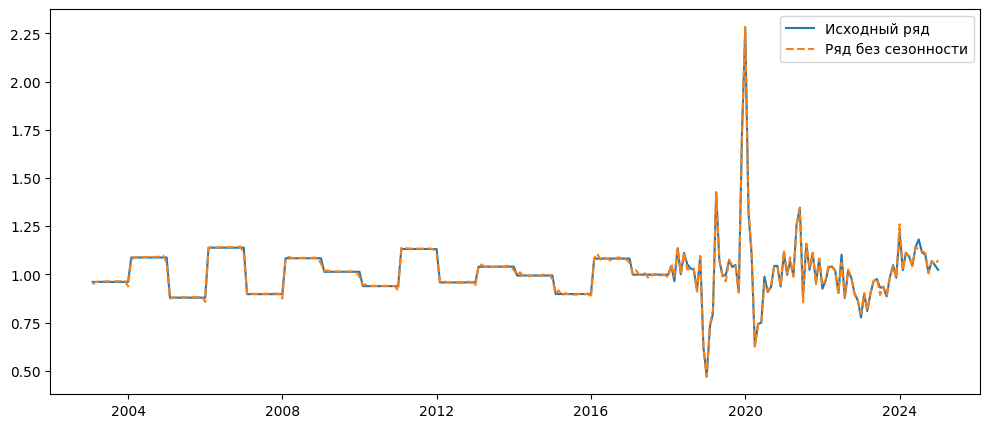

Cement


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant seasonal peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


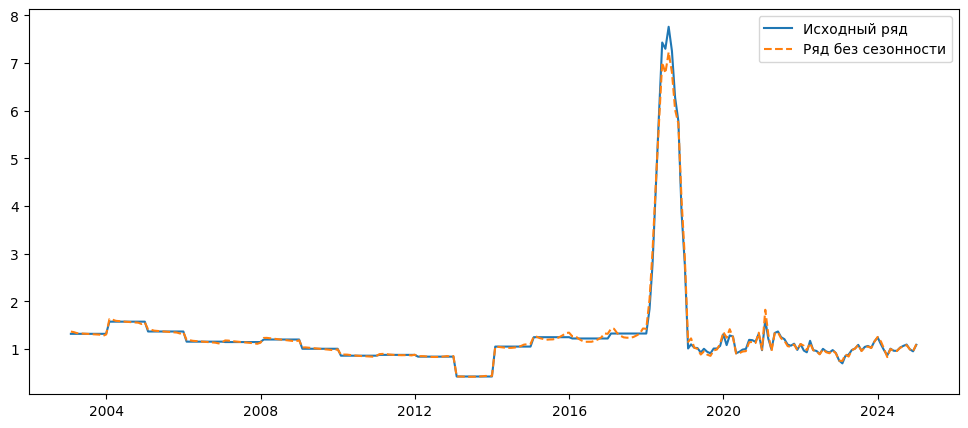

Chem


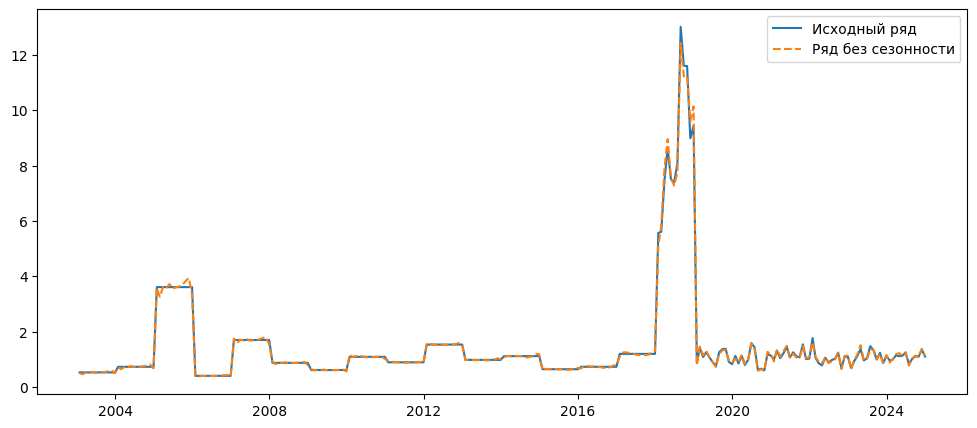

Coal


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


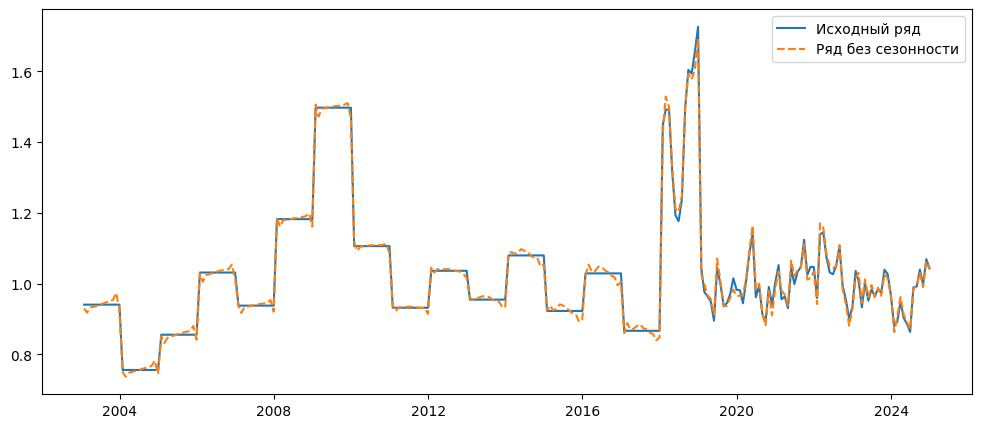

Coke


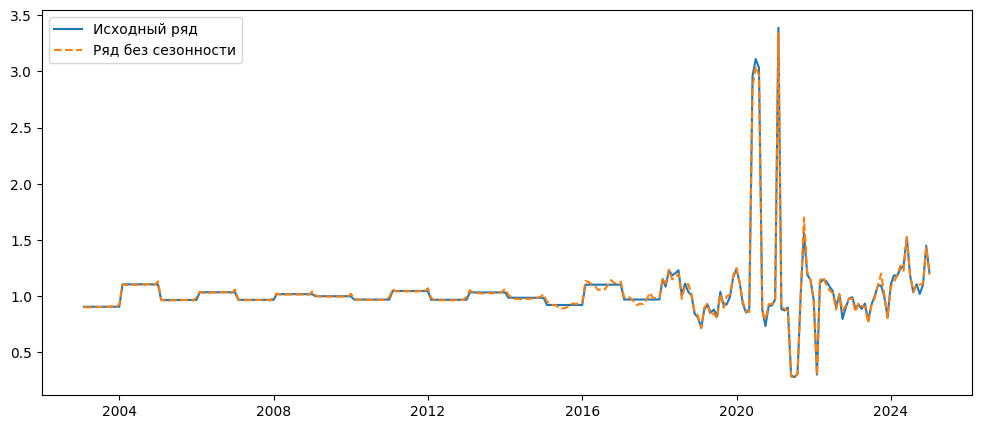

ColOre


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: Visually significant seasonal and trading day peaks have 
          been found in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)


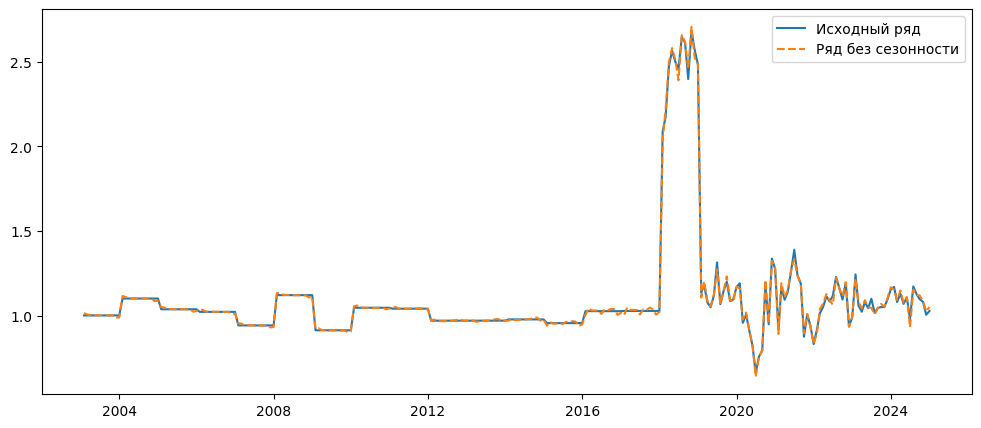

Drinks


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)


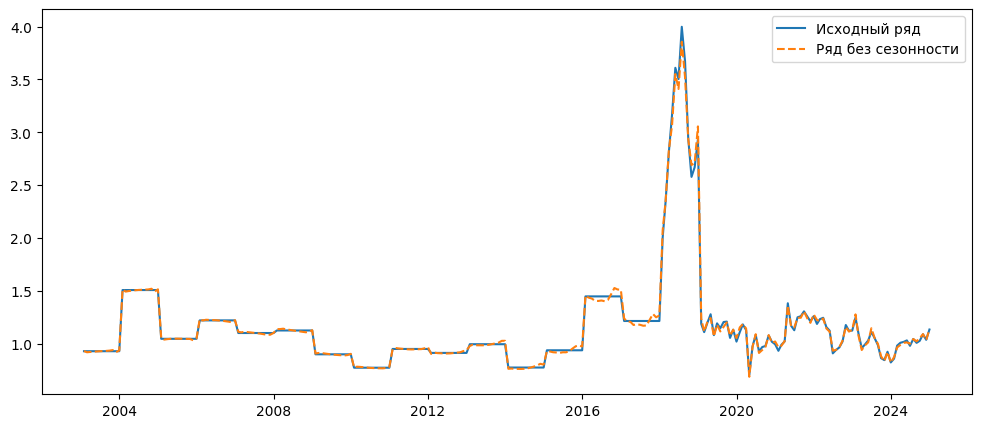

Earth


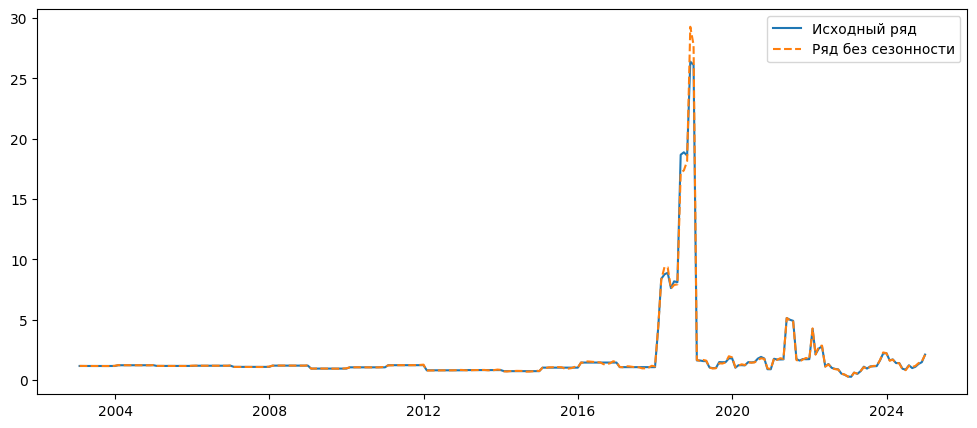

Fert


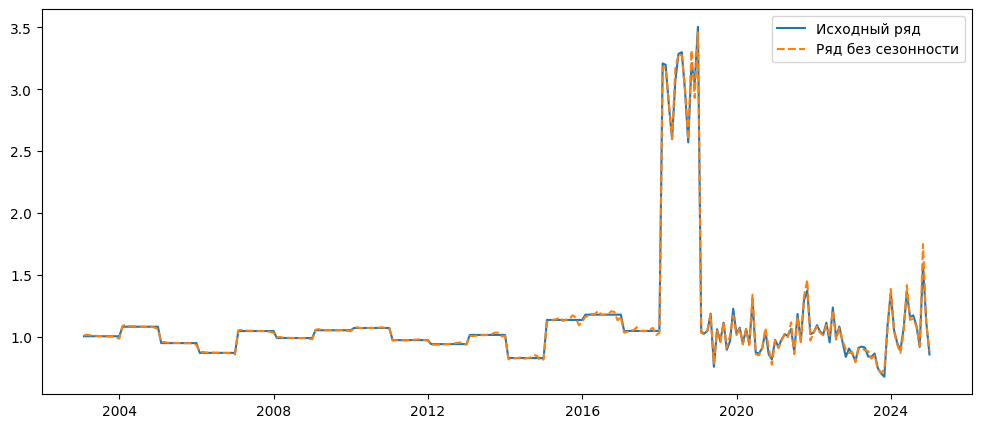

Iron


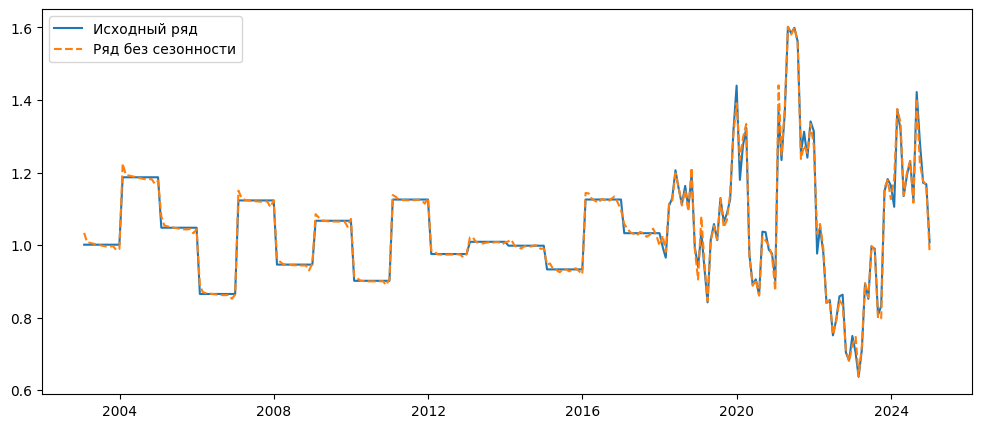

Lim


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


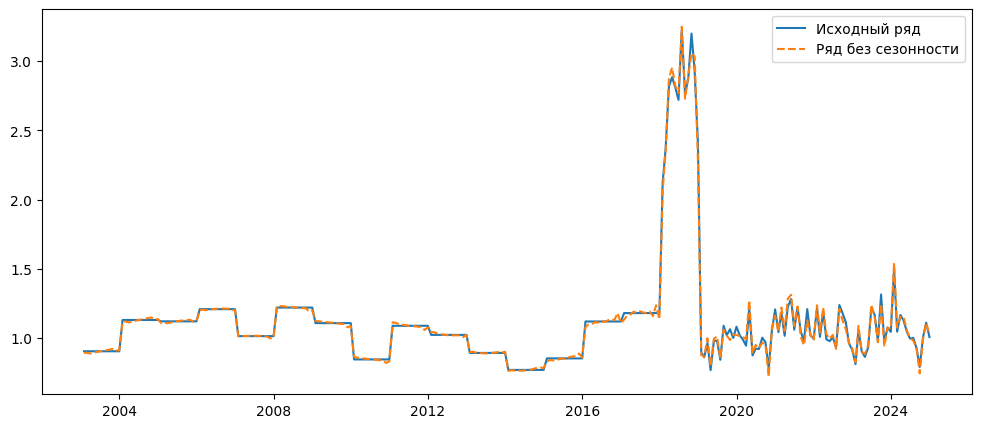

Oil


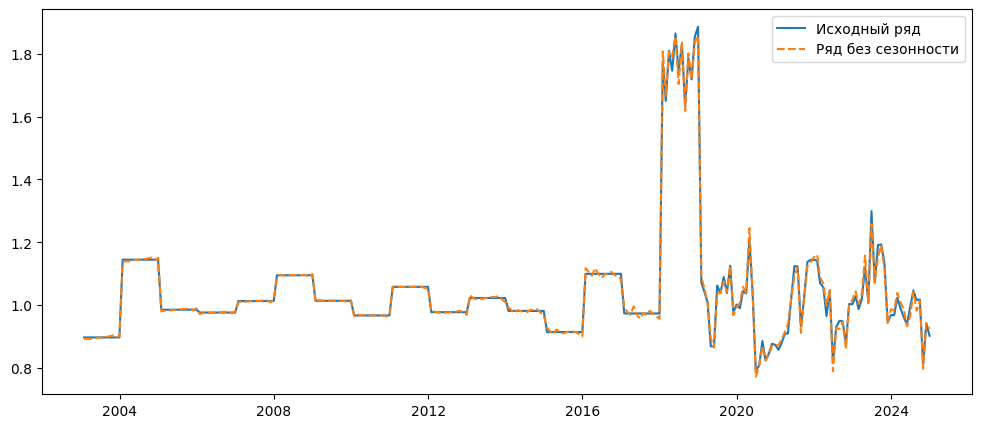

Petrol


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


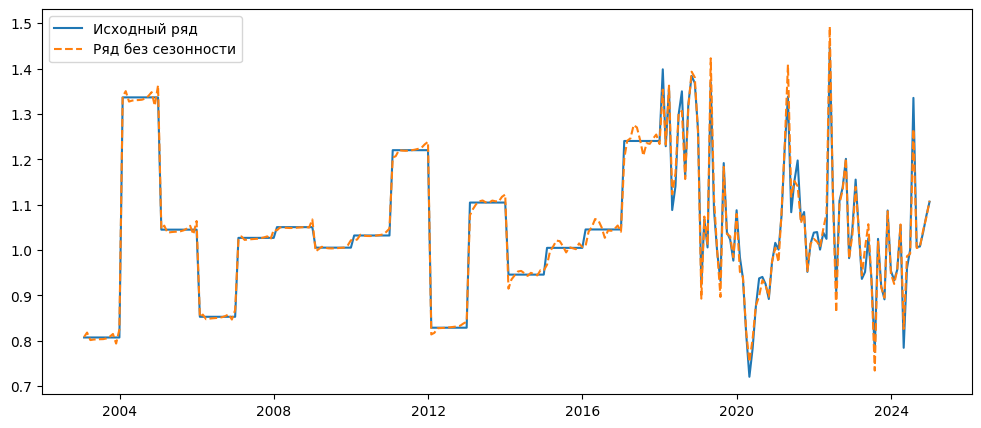

Scrap


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)


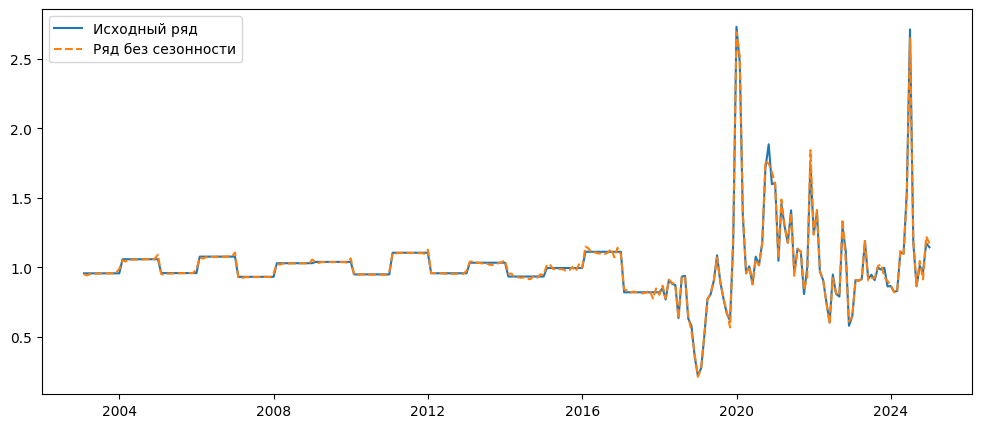

Wheat


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


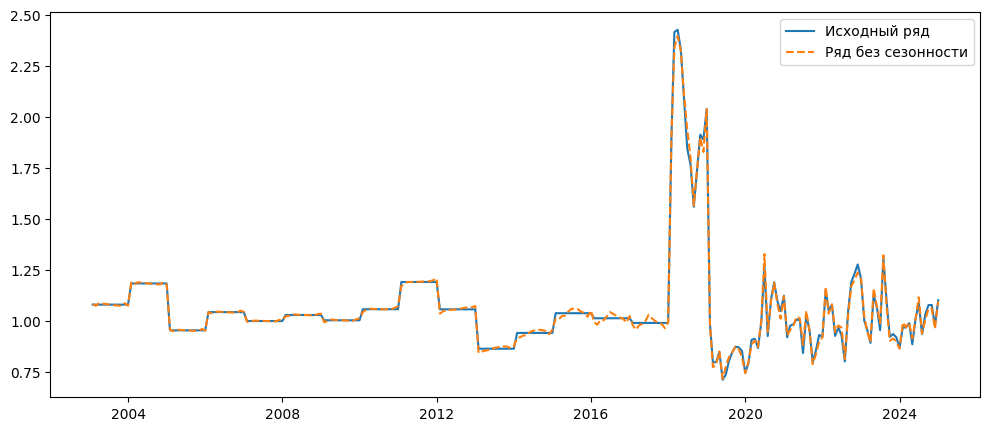

nFerr


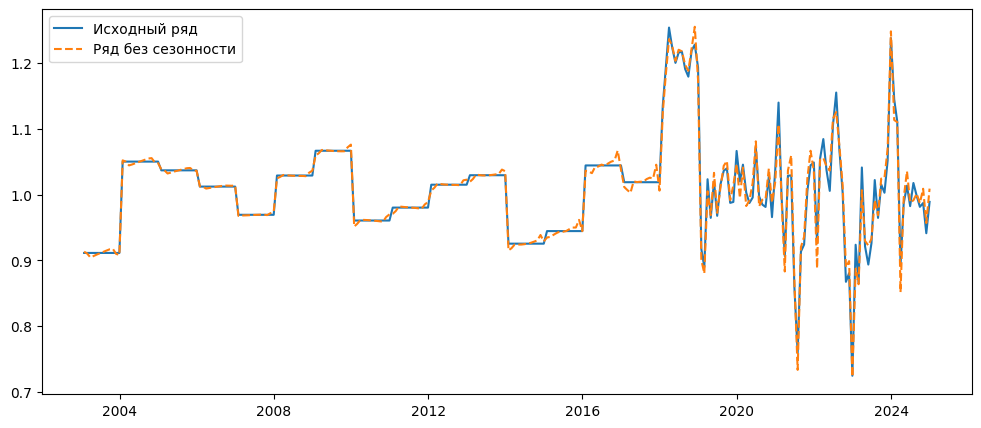

In [130]:
for idx, row in df_2003_2024_with_index.iterrows():

  data = row
  # Применяем X-13ARIMA-SEATS
  print(idx)
  res = sm.tsa.x13_arima_analysis(data, freq='M', outlier=False)

  # Достаем очищенный от сезонности ряд
  adjusted_series = res.seasadj

  # График результата
  import matplotlib.pyplot as plt
  plt.figure(figsize=(12,5))
  plt.plot(data, label="Исходный ряд")
  plt.plot(adjusted_series, label="Ряд без сезонности", linestyle="dashed")
  plt.legend()
  plt.show()